**Here we import all libraries needed**



In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, Model
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import os
from tensorflow.keras.preprocessing.text import Tokenizer

**Here we connect our program to google disc and load input data from it**

In [ ]:
# Mount Google Drive if using datasets stored there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set file paths (modify these paths based on where your files are stored)
train_path = '/content/drive/MyDrive/deep_learning_project/data/train'  # Adjust to the correct path
valid_path = '/content/drive/MyDrive/deep_learning_project/data/validation'  # Adjust to the correct path
test_path = '/content/drive/MyDrive/deep_learning_project/data/test'  # Adjust to the correct path

In [ ]:
# Load the train dataset
df_train_history = pd.read_parquet(os.path.join(train_path, 'history.parquet'))
df_train_behaviors = pd.read_parquet(os.path.join(train_path, 'behaviors.parquet'))
df_train_articles = pd.read_parquet(os.path.join(train_path, 'articles.parquet'))

# Load the validation dataset
df_valid_history = pd.read_parquet(os.path.join(valid_path, 'history.parquet'))
df_valid_behaviors = pd.read_parquet(os.path.join(valid_path, 'behaviors.parquet'))
df_valid_articles = pd.read_parquet(os.path.join(valid_path, 'articles.parquet'))

# Load the test dataset
df_test_history = pd.read_parquet(os.path.join(test_path, 'history.parquet'))
df_test_behaviors = pd.read_parquet(os.path.join(test_path, 'behaviors.parquet'))
df_test_articles = pd.read_parquet(os.path.join(test_path, 'articles.parquet'))

# Delete the article_ids_clicked in test set (so far we use validation set as a test set in true test set there is no such a column so we have to prepare the model for it)
df_test_behaviors.drop('article_ids_clicked', axis=1, inplace=True)

In [ ]:
# Ensure consistent data types for merging in train dataset
df_train_behaviors['article_id'] = df_train_behaviors['article_id'].fillna('-1').astype(str)
df_train_articles['article_id'] = df_train_articles['article_id'].astype(str)

# Ensure consistent data types for merging in validation dataset
df_valid_behaviors['article_id'] = df_valid_behaviors['article_id'].fillna('-1').astype(str)
df_valid_articles['article_id'] = df_valid_articles['article_id'].astype(str)

# Ensure consistent data types for merging in test dataset
df_test_behaviors['article_id'] = df_test_behaviors['article_id'].fillna('-1').astype(str)
df_test_articles['article_id'] = df_test_articles['article_id'].astype(str)

In [ ]:
unique_user_ids = df_train_history['user_id'].unique()
user_id_to_index = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}

In [ ]:
with open('/content/drive/MyDrive/deep_learning_project/data/user_id_to_index.pkl', 'wb') as f:
    pickle.dump(user_id_to_index, f)

In [ ]:
# EMBEDDINGS OF ARTICLES

# Import the embedding fle provided by the competition organizers
embedding_df = pd.read_parquet('/content/drive/MyDrive/deep_learning_project/data/embeddings/document_vector.parquet')

# Check the embedding vectors dimension
embedding_dim = len(embedding_df['document_vector'].iloc[0])

# Mapping article_id -> embedding index
article_to_index = {article_id: idx for idx, article_id in enumerate(embedding_df['article_id'])}

# Initialisation of embedding matrix
num_articles = len(article_to_index)
embedding_matrix = np.zeros((num_articles, embedding_dim))

# Puopulate the embedding matrix
for idx, row in embedding_df.iterrows():
    embedding_matrix[article_to_index[row['article_id']]] = np.array(row['document_vector'])

In [ ]:
import pickle
# Zapisz article_to_index
with open('/content/drive/MyDrive/deep_learning_project/data/article_to_index.pkl', 'wb') as f:
    pickle.dump(article_to_index, f)

# Zapisz embedding_matrix w pliku npz
np.save('/content/drive/MyDrive/deep_learning_project/data/embedding_matrix.npy', embedding_matrix)

# Zapisz embedding_dim też gdzieś, np. w pickle:
with open('/content/drive/MyDrive/deep_learning_project/data/embedding_dim.pkl', 'wb') as f:
    pickle.dump(embedding_dim, f)

In [ ]:
# # Sample 0.5% of each dataset to create smaller subsets
# df_train_history = df_train_history.sample(frac=0.005, random_state=42)
# df_train_behaviors = df_train_behaviors.sample(frac=0.005, random_state=42)
# df_train_articles = df_train_articles.sample(frac=0.005, random_state=42)

# df_valid_history = df_valid_history.sample(frac=0.005, random_state=42)
# df_valid_behaviors = df_valid_behaviors.sample(frac=0.005, random_state=42)
# df_valid_articles = df_valid_articles.sample(frac=0.005, random_state=42)

# df_test_history = df_test_history.sample(frac=0.005, random_state=42)
# df_test_behaviors = df_test_behaviors.sample(frac=0.005, random_state=42)
# df_test_articles = df_test_articles.sample(frac=0.005, random_state=42)

# # Subset the embedding dataframe
# # embedding_df = embedding_df.sample(frac=0.005, random_state=42)

# # # Recalculate the article-to-index mapping and embedding matrix for the smaller embedding_df
# # article_to_index = {article_id: idx for idx, article_id in enumerate(embedding_df['article_id'])}

# # # Reinitialize the embedding matrix
# # num_articles = len(article_to_index)
# # embedding_matrix = np.zeros((num_articles, embedding_dim))

# # # Populate the new embedding matrix
# # for idx, row in embedding_df.iterrows():
# #     embedding_matrix[article_to_index[row['article_id']]] = np.array(row['document_vector'])

# # # Your variables now refer to smaller subsets of the original data.


**Here we define functions which are used to pre-process the input data**

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to transform the history of the user into tensor containing the articles embeddings
def process_user_history(df_history, article_to_index, embedding_matrix, max_history_length):

    # Initialize a list to store padded embeddings
    article_embeddings = []

    for article_ids in df_history['article_id_fixed']:
        # Collect embeddings for valid article IDs
        embeddings = [embedding_matrix[article_to_index[article_id]]
                      for article_id in article_ids if article_id in article_to_index]

        # Pad or truncate to the fixed history length
        if len(embeddings) > max_history_length:
            embeddings = embeddings[:max_history_length]
        elif len(embeddings) < max_history_length:
            embeddings += [np.zeros(embedding_matrix.shape[1])] * (max_history_length - len(embeddings))

        article_embeddings.append(embeddings)

    # Convert to a NumPy array and ensure correct dtype
    padded_array = np.array(article_embeddings, dtype=np.float32)

    # Map user to index
    #user_id_to_index = {user_id: idx for idx, user_id in enumerate(df_history['user_id'].unique())}

    return tf.convert_to_tensor(padded_array)#, user_id_to_index

In [ ]:
import pandas as pd

def compute_article_age(df_behaviors, df_articles):
    # Explode 'article_ids_inview' to have one article per row
    df_behaviors_exploded = df_behaviors.explode('article_ids_inview')

    # Merge with articles to get 'published_time', specify suffixes to avoid column name conflicts
    df_merged = df_behaviors_exploded.merge(
        df_articles[['article_id', 'published_time']],
        left_on='article_ids_inview',
        right_on='article_id',
        how='left',
        suffixes=('', '_article')  # Specifying suffixes
    )

    # Convert timestamps to datetime
    df_merged['impression_time'] = pd.to_datetime(df_merged['impression_time'])
    df_merged['published_time'] = pd.to_datetime(df_merged['published_time'])

    # Compute article age in hours
    df_merged['article_age'] = (df_merged['impression_time'] - df_merged['published_time']).dt.total_seconds() / 3600.0
    df_merged['article_age'] = df_merged['article_age'].fillna(0)

    # Handle missing 'article_ids_clicked' in test set
    if 'article_ids_clicked' in df_merged.columns:
        agg_dict = {
            'user_id': 'first',
            'article_id': 'first',  # From df_behaviors_exploded
            'session_id': 'first',
            'article_ids_inview': list,
            'article_ids_clicked': 'first',
            'article_age': list,
            'impression_time': 'first',
            'hour_of_day': 'first',
            'day_of_week': 'first',
        }
    else:
        agg_dict = {
            'user_id': 'first',
            'article_id': 'first',  # From df_behaviors_exploded
            'session_id': 'first',
            'article_ids_inview': list,
            'article_age': list,
            'impression_time': 'first',
            'hour_of_day': 'first',
            'day_of_week': 'first',
        }

    df_grouped = df_merged.groupby('impression_id').agg(agg_dict).reset_index()

    return df_grouped

In [ ]:
def compute_session_time_features(df_behaviors):
    df_behaviors['impression_time'] = pd.to_datetime(df_behaviors['impression_time'])
    df_behaviors['hour_of_day'] = df_behaviors['impression_time'].dt.hour
    df_behaviors['day_of_week'] = df_behaviors['impression_time'].dt.weekday  # 0=Monday, 6=Sunday
    return df_behaviors

In [ ]:
def compute_user_activity_features(df_behaviors):
    df_behaviors = df_behaviors.sort_values(['user_id', 'impression_time'])
    df_behaviors['time_since_last_session'] = df_behaviors.groupby('user_id')['impression_time'].diff().dt.total_seconds().fillna(0)
    return df_behaviors

In [ ]:
def pad_or_truncate_list(lst, target_length, padding_value):
    lst = list(lst)
    if len(lst) > target_length:
        return lst[:target_length]
    else:
        return lst + [padding_value] * (target_length - len(lst))

In [ ]:
def build_in_session_histories(df_behaviors):
    # Sort by user_id, session_id, and impression_time
    df_behaviors = df_behaviors.sort_values(['user_id', 'session_id', 'impression_time'])

    # Initialize a dictionary to store in-session histories
    in_session_histories = {}

    # Group by session
    grouped = df_behaviors.groupby(['user_id', 'session_id'])

    # Iterate over each session
    for (user_id, session_id), group in grouped:
        viewed_articles = []
        for idx, row in group.iterrows():
            # Store the current viewed articles
            in_session_histories[idx] = list(viewed_articles)

            # Update the viewed_articles list with the current article
            article_id = row['article_id']
            if article_id is not None:
                viewed_articles.append(article_id)
    return in_session_histories

In [ ]:
def generate_session_labels(df_behaviors, article_to_index, embedding_matrix, max_articles_in_view=10, max_in_session_history=5, max_popularity_articles=10):
    session_data = []

    for _, row in df_behaviors.iterrows():
        user_id = row['user_id']
        impression_id = row['impression_id']
        articles_in_view = np.array(row['article_ids_inview'])
        articles_clicked = set(row['article_ids_clicked']) if row['article_ids_clicked'] is not None else set()
        in_session_history = row['in_session_history']

        # Generate embeddings for in-session history
        in_session_embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in in_session_history
        ]

        # Pad or truncate to max_in_session_history
        in_session_embeddings = pad_or_truncate_list(in_session_embeddings, max_in_session_history, np.zeros(embedding_matrix.shape[1]))

        # Popularity articles embeddings
        popularity_articles = row['popularity_articles']
        popularity_embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in popularity_articles
        ]
        popularity_embeddings = pad_or_truncate_list(popularity_embeddings, max_popularity_articles, np.zeros(embedding_matrix.shape[1]))

        # Existing code for article embeddings and labels
        embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in articles_in_view
        ]
        embeddings = pad_or_truncate_list(embeddings, max_articles_in_view, np.zeros(embedding_matrix.shape[1]))

        labels = np.isin(articles_in_view, list(articles_clicked)).astype(int)
        labels = pad_or_truncate_list(labels, max_articles_in_view, 0)

        session_data.append({
            'user_id': user_id,
            'impression_id': impression_id,
            'article_embeddings': embeddings,
            'in_session_embeddings': in_session_embeddings,
            'popularity_embeddings': popularity_embeddings,
            'labels': labels,
            # Include other features as needed
        })

    return pd.DataFrame(session_data)

In [ ]:
def prepare_test_sessions(df_behaviors, article_to_index, embedding_matrix, max_articles_in_view=10, max_in_session_history=5, max_popularity_articles=10):
    session_data = []

    for _, row in df_behaviors.iterrows():
        user_id = row['user_id']
        impression_id = row['impression_id']
        articles_in_view = np.array(row['article_ids_inview'])

        # In-session history embeddings
        in_session_history = row.get('in_session_history', [])
        in_session_embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in in_session_history
        ]
        in_session_embeddings = pad_or_truncate_list(in_session_embeddings, max_in_session_history, np.zeros(embedding_matrix.shape[1]))

        # Popularity articles embeddings
        popularity_articles = row.get('popularity_articles', [])
        popularity_embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in popularity_articles
        ]
        popularity_embeddings = pad_or_truncate_list(popularity_embeddings, max_popularity_articles, np.zeros(embedding_matrix.shape[1]))

        # Article embeddings
        embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in articles_in_view
        ]
        embeddings = pad_or_truncate_list(embeddings, max_articles_in_view, np.zeros(embedding_matrix.shape[1]))

        session_data.append({
            'user_id': user_id,
            'impression_id': impression_id,
            'article_embeddings': embeddings,
            'in_session_embeddings': in_session_embeddings,
            'popularity_embeddings': popularity_embeddings,
            # No labels since we don't have 'article_ids_clicked'
        })

    return pd.DataFrame(session_data)

In [ ]:
def compute_popularity_features(df_behaviors, popularity_window_hours, top_n=10):
    """
    Adds a 'popularity_articles' column to df_behaviors, which lists the top N articles
    popular in the last 'popularity_window_hours' before each impression.
    """
    # Convert 'impression_time' to datetime
    df_behaviors['impression_time'] = pd.to_datetime(df_behaviors['impression_time'])

    # Create a DataFrame 'df_views' containing each viewed article with the corresponding time
    df_views = df_behaviors[['impression_time', 'article_id']].dropna(subset=['article_id'])

    # Set 'impression_time' as the index and sort it
    df_views.set_index('impression_time', inplace=True)
    df_views.sort_index(inplace=True)

    # Initialize a cache dictionary to store popularity for each time period
    popularity_cache = {}

    # Time window in Timedelta
    time_window = pd.Timedelta(hours=popularity_window_hours)

    # Iterate through unique impression times
    impression_times = df_behaviors['impression_time'].unique()

    for time in impression_times:
        if time in popularity_cache:
            continue
        # Define the time window
        start_time = time - time_window
        # Ensure that start_time and time are Timestamps
        start_time = pd.to_datetime(start_time)
        time = pd.to_datetime(time)
        # Filter views in the time window
        views_in_window = df_views.loc[start_time:time]
        # Count article views
        article_counts = views_in_window['article_id'].value_counts()
        # Get the top N most popular articles
        popular_articles = article_counts.head(top_n).index.tolist()
        # Store results in the cache
        popularity_cache[time] = popular_articles

    # Map popularity to df_behaviors
    df_behaviors['popularity_articles'] = df_behaviors['impression_time'].map(popularity_cache)

    # Replace NaN with an empty list if there are no popular articles
    df_behaviors['popularity_articles'] = df_behaviors['popularity_articles'].apply(lambda x: x if isinstance(x, list) else [])

    return df_behaviors

In [ ]:
def create_tf_dataset(df_labeled_sessions, user_id_to_index, batch_size):
    user_indices = df_labeled_sessions['user_id'].map(user_id_to_index).fillna(0).astype(int).to_numpy()
    article_embeddings = np.stack(df_labeled_sessions['article_embeddings'].to_numpy())
    in_session_embeddings = np.stack(df_labeled_sessions['in_session_embeddings'].to_numpy())
    popularity_embeddings = np.stack(df_labeled_sessions['popularity_embeddings'].to_numpy())
    labels = np.stack(df_labeled_sessions['labels'].to_numpy())

    """
    # Convert to TensorFlow tensors and ensure they are on the CPU
    with tf.device('/CPU:0'):  # Force tensors to reside on the CPU
        user_indices = tf.convert_to_tensor(user_indices, dtype=tf.int32)
        article_embeddings = tf.convert_to_tensor(article_embeddings, dtype=tf.float32)
        in_session_embeddings = tf.convert_to_tensor(in_session_embeddings, dtype=tf.float32)
        labels = tf.convert_to_tensor(labels, dtype=tf.int32) # Assuming labels are integers
    """

    dataset = tf.data.Dataset.from_tensor_slices(
        ((user_indices, article_embeddings, in_session_embeddings, popularity_embeddings), labels)
    ).batch(batch_size)

    return dataset

In [ ]:
def create_tf_dataset_for_prediction(df_sessions, user_id_to_index, batch_size):
    user_indices = df_sessions['user_id'].map(user_id_to_index).astype(int).to_numpy()
    article_embeddings = np.stack(df_sessions['article_embeddings'].to_numpy())
    in_session_embeddings = np.stack(df_sessions['in_session_embeddings'].to_numpy())
    popularity_embeddings = np.stack(df_sessions['popularity_embeddings'].to_numpy())

    dataset = tf.data.Dataset.from_tensor_slices((
        (user_indices, article_embeddings, in_session_embeddings, popularity_embeddings)
    ))

    return dataset.batch(batch_size)

**Here we define the model class and its sub-classes**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LayerNormalization, Dropout
from tensorflow.keras.regularizers import l2

class UserEncoder(Model):
    def __init__(self, embedding_dim, num_heads, attention_dim, dropout_rate=0.2, **kwargs):
        super(UserEncoder, self).__init__(**kwargs)

        # Self-attention layer
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.layer_norm1 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(dropout_rate)

        # Additive attention layer
        self.additive_attention_dense = layers.Dense(embedding_dim, activation='tanh')
        self.layer_norm2 = layers.LayerNormalization()
        self.dropout2 = layers.Dropout(dropout_rate)

        # Extra dense layer
        self.attention_score_dense = layers.Dense(1)
        self.softmax = layers.Softmax(axis=1)

    def call(self, inputs):

        # Self-attention layer
        attention_output = self.multi_head_attention(inputs, inputs)
        attention_output = self.layer_norm1(attention_output)
        attention_output = self.dropout1(attention_output)

        # Additive attention layer
        additive_attention_output = self.additive_attention_dense(attention_output)
        additive_attention_output = self.layer_norm2(additive_attention_output)
        additive_attention_output = self.dropout2(additive_attention_output)

        # Dense layer
        attention_scores = self.attention_score_dense(additive_attention_output)
        attention_weights = self.softmax(attention_scores)

        weighted_output = tf.reduce_sum(attention_output * attention_weights, axis=1)
        return weighted_output

In [ ]:
class InSessionEncoder(Model):
    def __init__(self, embedding_dim, num_heads, **kwargs):
        super(InSessionEncoder, self).__init__(**kwargs)
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.layer_norm = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.2)
        self.output_layer = layers.Dense(embedding_dim)

    def call(self, inputs):
        attention_output = self.multi_head_attention(inputs, inputs)
        attention_output = self.layer_norm(attention_output)
        attention_output = self.dropout(attention_output)
        # Aggregate the outputs
        in_session_representation = tf.reduce_mean(attention_output, axis=1)
        in_session_representation = self.output_layer(in_session_representation)
        return in_session_representation

In [ ]:
class PopularityEncoder(Model):
    def __init__(self, embedding_dim, num_heads, **kwargs):
        super(PopularityEncoder, self).__init__(**kwargs)
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.layer_norm = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.2)
        self.output_layer = layers.Dense(embedding_dim)

    def call(self, inputs):
        # inputs: tensor with dimensions: (batch_size, max_popularity_articles, embedding_dim)
        attention_output = self.multi_head_attention(inputs, inputs)
        attention_output = self.layer_norm(attention_output)
        attention_output = self.dropout(attention_output)
        # Aggregation of outputs
        popularity_representation = tf.reduce_mean(attention_output, axis=1)
        popularity_representation = self.output_layer(popularity_representation)
        return popularity_representation

In [ ]:
class ClickPredictor(Model):
    def __init__(self, input_dim, **kwargs):
        super(ClickPredictor, self).__init__(**kwargs)
        self.dense1 = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.dropout1 = layers.Dropout(0.2)
        self.dense2 = layers.Dense(128, activation='relu')
        self.dropout2 = layers.Dropout(0.2)
        self.dense3 = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        click_probability = self.dense3(x)
        return click_probability

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.metrics import AUC

class NewsRecommendationModel(Model):
    def __init__(self, user_histories_tensor, embedding_dim, num_heads, attention_dim, **kwargs):
        super(NewsRecommendationModel, self).__init__(**kwargs)
        self.user_histories_tensor = user_histories_tensor
        self.user_encoder = UserEncoder(embedding_dim=embedding_dim, num_heads=num_heads, attention_dim=attention_dim)
        self.in_session_encoder = InSessionEncoder(embedding_dim=embedding_dim, num_heads=num_heads)
        self.popularity_encoder = PopularityEncoder(embedding_dim=embedding_dim, num_heads=num_heads)

        # Self-attention layer
        self.self_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(0.2)

        # Dense layer for user representation projection
        self.user_projection = layers.Dense(embedding_dim, activation='relu')

        self.click_predictor = ClickPredictor(input_dim=embedding_dim)

    def call(self, inputs):
        user_indices, article_embeddings, in_session_embeddings, popularity_embeddings = inputs

        # User representation
        user_histories = tf.gather(self.user_histories_tensor, user_indices)
        user_representation = self.user_encoder(user_histories)

        # In-session representation
        in_session_representation = self.in_session_encoder(in_session_embeddings)

        # Popularity representation
        popularity_representation = self.popularity_encoder(popularity_embeddings)

        # Combining user representations
        combined_user_representation = tf.concat([user_representation, in_session_representation, popularity_representation], axis=-1)  # Shape: (batch_size, combined_dim)

        # Projection to embedding_dim
        combined_user_representation = self.user_projection(combined_user_representation)  # Shape: (batch_size, embedding_dim)

        # Preparing data for attention
        batch_size = tf.shape(article_embeddings)[0]
        num_articles = tf.shape(article_embeddings)[1]

        # Expanding dimensions and concatenation
        user_representation_expanded = tf.expand_dims(combined_user_representation, axis=1)  # Shape: (batch_size, 1, embedding_dim)
        sequence = tf.concat([user_representation_expanded, article_embeddings], axis=1)  # Shape: (batch_size, num_articles + 1, embedding_dim)

        # Applying self-attention
        attention_output = self.self_attention(sequence, sequence)
        attention_output = self.dropout(attention_output)
        attention_output = self.layer_norm(sequence + attention_output)

        # Extracting article representations after attention (skipping the first element, which is the user representation)
        article_attention_output = attention_output[:, 1:, :]  # Shape: (batch_size, num_articles, embedding_dim)

        # Flattening and click prediction for each article
        article_flat = tf.reshape(article_attention_output, [-1, embedding_dim])  # Shape: (batch_size * num_articles, embedding_dim)
        click_probabilities_flat = self.click_predictor(article_flat)  # Shape: (batch_size * num_articles, 1)
        click_probabilities = tf.reshape(click_probabilities_flat, [batch_size, num_articles])  # Shape: (batch_size, num_articles)

        return click_probabilities



**Here we define all the hyperparameters used in the model**

In [ ]:
# DEFINE ALL THE HYPERPARAMETERS
embedding_dim = 300             # Dimension of the article embedding vectors
num_heads = 16                  # Number of attention heads in the attention layer
attention_dim = 32              # Dimension of the attention space
batch_size = 64                 # Number of samples used in each training iteration
epochs_num = 16                 # Number of times the model will iterate over the entire training dataset
initial_learning_rate=0.001     # Initial value of learning rate (learning rate is dynamically set by the scheduler)
max_history_length = 32         # Maximum length of user history considered by the model
max_articles_in_view = 10       # Maximum number of articles in a user's viewing session (if applicable)
popularity_window_hours = 48    # Number of hours to consider for popularity calculation
top_N_popular_articles = 10     # Number of top popular articles to consider

**Here we pass the input data through the predefined functions (input data pre-processing)**

In [ ]:
import pickle

with open('/content/drive/MyDrive/deep_learning_project/data/article_to_index.pkl', 'rb') as f:
    article_to_index = pickle.load(f)

embedding_matrix = np.load('/content/drive/MyDrive/deep_learning_project/data/embedding_matrix.npy')

with open('/content/drive/MyDrive/deep_learning_project/data/embedding_dim.pkl', 'rb') as f:
    embedding_dim = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/deep_learning_project/data/user_id_to_index.pkl', 'rb') as f:
    user_id_to_index = pickle.load(f)

In [ ]:
df_train_behaviors = compute_session_time_features(df_train_behaviors)
df_train_behaviors = compute_user_activity_features(df_train_behaviors)
df_train_behaviors = compute_article_age(df_train_behaviors, df_train_articles)
df_train_behaviors = compute_popularity_features(df_train_behaviors, popularity_window_hours, top_N_popular_articles)

# Zapisz gotowy df_behaviors do pliku:
df_train_behaviors.to_parquet('/content/drive/MyDrive/deep_learning_project/data/train_full_preprocessed.parquet')

In [ ]:
df_valid_behaviors = compute_session_time_features(df_valid_behaviors)
df_valid_behaviors = compute_user_activity_features(df_valid_behaviors)
df_valid_behaviors = compute_article_age(df_valid_behaviors, df_valid_articles)
df_valid_behaviors = compute_popularity_features(df_valid_behaviors, popularity_window_hours, top_N_popular_articles)

# Zapisz gotowy df_behaviors do pliku:
df_valid_behaviors.to_parquet('/content/drive/MyDrive/deep_learning_project/data/valid_full_preprocessed.parquet')

In [ ]:
"""
def prepare_data(df_history, df_behaviors, df_articles, article_to_index, embedding_matrix, max_history_length, popularity_window_hours, top_N_popular_articles, user_id_to_index, is_training=True):

    # Compute temporal features
    df_behaviors = compute_session_time_features(df_behaviors)
    df_behaviors = compute_user_activity_features(df_behaviors)
    df_behaviors = compute_article_age(df_behaviors, df_articles)

    # Compute and add in-session history
    in_session_histories = build_in_session_histories(df_behaviors)
    df_behaviors['in_session_history'] = df_behaviors.index.map(in_session_histories)

    # Compute popularity features
    df_behaviors = compute_popularity_features(df_behaviors, popularity_window_hours, top_N_popular_articles)

    # Prepare user histories
    #user_histories_tensor, user_id_to_index = process_user_history(
    #    df_history, article_to_index, embedding_matrix, max_history_length, user_id_to_index
    #)
    user_histories_tensor = process_user_history(
        df_history, article_to_index, embedding_matrix, max_history_length
    )

    # Generate session labels including temporal features
    df_labeled_sessions = generate_session_labels(df_behaviors, article_to_index, embedding_matrix)

    # Create dataset including temporal features
    dataset = create_tf_dataset(df_labeled_sessions, user_id_to_index, batch_size=32)

    return dataset, user_histories_tensor, user_id_to_index
    """

def prepare_data(df_history, df_behaviors, df_articles, article_to_index, embedding_matrix, max_history_length, user_id_to_index, is_training=True):
    # Zakładamy, że df_behaviors jest już wstępnie przetworzony i ma kolumny popularity_articles, hour_of_day, day_of_week, article_age itp.

    in_session_histories = build_in_session_histories(df_behaviors)
    df_behaviors['in_session_history'] = df_behaviors.index.map(in_session_histories)

    # Nie wywołujemy compute_popularity_features, compute_session_time_features, itd. bo już zostały zrobione globalnie

    # Teraz process_user_history (zakładając że user_id_to_index i reszta jest globalna lub przekazana)
    user_histories_tensor = process_user_history(
        df_history, article_to_index, embedding_matrix, max_history_length
    )

    # Generate session labels
    df_labeled_sessions = generate_session_labels(df_behaviors, article_to_index, embedding_matrix)

    # Create dataset
    dataset = create_tf_dataset(df_labeled_sessions, user_id_to_index, batch_size=32)

    return dataset, user_histories_tensor

# Prepare datasets
#train_dataset, train_user_histories_tensor, user_id_to_index = prepare_data(df_train_history, df_train_behaviors, df_train_articles, article_to_index, embedding_matrix, max_history_length, popularity_window_hours, top_N_popular_articles, user_id_to_index, is_training=True)
#validation_dataset, _, _ = prepare_data(df_valid_history, df_valid_behaviors, df_valid_articles, article_to_index, embedding_matrix, max_history_length, popularity_window_hours, top_N_popular_articles, user_id_to_index, is_training=False)

**Here we train and test the model**

In [ ]:

"""
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create a model instance
model = NewsRecommendationModel(
                                user_histories_tensor=train_user_histories_tensor,
                                embedding_dim=embedding_dim,
                                num_heads=num_heads,
                                attention_dim=attention_dim
                              )

# Define the loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Define the scheduler (to dynamically set the optimal learning rate)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9)

# Create optimizer using above scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define the callback (reduces the learning rate when the validation loss stops to decrease)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

# Compile the model
model.compile(optimizer=optimizer,  # Use the optimizer instance
              loss=loss_fn,
              metrics=[tf.keras.metrics.AUC(name="auc")])

# Train the model
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs_num,
    callbacks=[reduce_lr]
)
"""

Epoch 1/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 54s 51ms/step - auc: 0.6720 - loss: 0.4334 - val_auc: 0.7316 - val_loss: 0.2727 - learning_rate: 9.9189e-04
Epoch 2/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - auc: 0.7400 - loss: 0.2663 - val_auc: 0.7287 - val_loss: 0.2625 - learning_rate: 9.8384e-04
Epoch 3/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - auc: 0.7485 - loss: 0.2581 - val_auc: 0.7237 - val_loss: 0.2635 - learning_rate: 9.7586e-04
Epoch 4/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - auc: 0.7524 - loss: 0.2564 - val_auc: 0.7201 - val_loss: 0.2644 - learning_rate: 9.6795e-04
Epoch 5/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - auc: 0.7556 - loss: 0.2554 - val_auc: 0.7169 - val_loss: 0.2685 - learning_rate: 9.6010e-04
Epoch 6/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - auc: 0.7586 - loss: 0.2545 - val_auc: 0.7201 - val_loss: 0.2657 - learning_rate: 9.5231e-04
Epoch 7/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - auc: 0.7610 - loss: 0.2538 - val_auc: 0.7234 - val_loss:

In [ ]:
import pandas as pd
import numpy as np

# Określ rozmiar chunków, np. 100_000 wierszy na część (dostosuj do dostępnej pamięci)
chunk_size = 25_000
num_chunks = len(df_train_behaviors) // chunk_size + int(len(df_train_behaviors) % chunk_size != 0)

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i+1)*chunk_size, len(df_train_behaviors))

    # Wytnij fragment z behaviors
    df_beh_chunk = df_train_behaviors.iloc[start_idx:end_idx].copy()

    # Aby poprawnie wyciąć fragment z history, musisz wybrać wiersze dla użytkowników występujących w df_beh_chunk
    # Jeżeli 'user_id' jest kluczem łączącym z history, możesz go użyć:
    user_ids_in_chunk = df_beh_chunk['user_id'].unique()
    df_hist_chunk = df_train_history[df_train_history['user_id'].isin(user_ids_in_chunk)].copy()
    # Podobnie jeśli potrzebne są artykuły, to zwykle articles jest pełne i to jest metadane,
    # więc w wielu przypadkach nie dzielimy articles, a używamy pełnego zbioru artykułów.
    # Ale jeśli chcesz też dzielić articles, to wybierz np. artykuły pojawiające się w tym chunku:
    # article_ids_in_chunk = np.unique(np.concatenate(df_beh_chunk['article_ids_inview'].values))
    # df_articles_chunk = df_full_articles[df_full_articles['article_id'].isin(article_ids_in_chunk)].copy()
    # Jeśli artykuły są globalne i potrzebne w całości, pomiń ten krok i zawsze używaj pełnych articles.

    # Zapisz część do parquet
    df_beh_chunk.to_parquet(f'/content/drive/MyDrive/deep_learning_project/data/train/train_behaviors_part{i+1}.parquet')
    df_hist_chunk.to_parquet(f'/content/drive/MyDrive/deep_learning_project/data/train/train_history_part{i+1}.parquet')

    # Jeśli zdecydowałeś się też dzielić articles:
    # df_articles_chunk.to_parquet(f'/content/drive/MyDrive/deep_learning_project/data/train/train_articles_part{i+1}.parquet')

# Po tym etapie masz wiele części train_behaviors_partX.parquet i train_history_partX.parquet.
# Możesz do nich odwołać się w liście train_parts.

In [ ]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os

# Tworzymy model raz
from tensorflow.keras.optimizers.schedules import ExponentialDecay
loss_fn = tf.keras.losses.BinaryCrossentropy()
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Na tym etapie nie mamy jeszcze user_histories_tensor, bo weźmiemy go z pierwszej partii danych
# Zrobimy to w pętli, inicjalizując model dopiero po wczytaniu pierwszego chunka

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Zakładamy że mamy listę plików z podzielonymi danymi treningowymi i walidacyjnymi:
train_parts = [
    '/content/drive/MyDrive/deep_learning_project/data/train/train_behaviors_part1.parquet',
    '/content/drive/MyDrive/deep_learning_project/data/train/train_behaviors_part2.parquet',
    '/content/drive/MyDrive/deep_learning_project/data/train/train_behaviors_part3.parquet',
    '/content/drive/MyDrive/deep_learning_project/data/train/train_behaviors_part4.parquet',
    '/content/drive/MyDrive/deep_learning_project/data/train/train_behaviors_part5.parquet',
    '/content/drive/MyDrive/deep_learning_project/data/train/train_behaviors_part6.parquet',
    '/content/drive/MyDrive/deep_learning_project/data/train/train_behaviors_part7.parquet',
    '/content/drive/MyDrive/deep_learning_project/data/train/train_behaviors_part8.parquet',
    '/content/drive/MyDrive/deep_learning_project/data/train/train_behaviors_part9.parquet',
    '/content/drive/MyDrive/deep_learning_project/data/train/train_behaviors_part10.parquet',
]

valid_behaviors_path = '/content/drive/MyDrive/deep_learning_project/data/valid_full_preprocessed.parquet'
valid_history_path = '/content/drive/MyDrive/deep_learning_project/data/validation/history.parquet'
valid_articles_path = '/content/drive/MyDrive/deep_learning_project/data/validation/articles.parquet'

# Najpierw trenujemy na pierwszej części aby zainicjalizować model
df_train_behaviors_part1 = pd.read_parquet(train_parts[0])
df_train_history_part1 = pd.read_parquet(train_parts[0].replace('behaviors','history'))
df_train_articles = pd.read_parquet('/content/drive/MyDrive/deep_learning_project/data/train/articles.parquet')
# zakładam że articles nie jest dzielone, bo to metadane wszystkich artykułów

train_dataset_part1, train_user_histories_tensor_part1 = prepare_data(
    df_train_history_part1, df_train_behaviors_part1, df_train_articles,
    article_to_index, embedding_matrix, max_history_length, user_id_to_index, is_training=True
)

# Zainicjalizuj model
model = NewsRecommendationModel(
    user_histories_tensor=train_user_histories_tensor_part1,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    attention_dim=attention_dim
)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[tf.keras.metrics.AUC(name="auc")])

# Trenuj na pierwszej części
print("Training on part: 1")
model.fit(train_dataset_part1, epochs=10)  # Możesz ustawić epochs inaczej, albo loopować.

# Dla kolejnych części aktualizujemy user_histories_tensor i kontynuujemy trening
i=1
for part_path in train_parts[1:]:
    i+=1
    df_train_behaviors_part = pd.read_parquet(part_path)
    df_train_history_part = pd.read_parquet(part_path.replace('behaviors','history'))

    train_dataset_part, train_user_histories_tensor_part = prepare_data(
        df_train_history_part, df_train_behaviors_part, df_train_articles,
        article_to_index, embedding_matrix, max_history_length, user_id_to_index, is_training=True
    )

    # Zaktualizuj user_histories_tensor w modelu
    model.user_histories_tensor = train_user_histories_tensor_part

    print(f"Training on part: {i}")
    model.fit(train_dataset_part, epochs=10)  # kontynuujesz trening

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# Po zakończeniu treningu na wszystkich częściach, walidacja
df_valid_behaviors = pd.read_parquet('/content/drive/MyDrive/deep_learning_project/data/valid_full_preprocessed.parquet')
df_valid_history = pd.read_parquet(valid_history_path)
df_valid_articles = pd.read_parquet(valid_articles_path)

valid_dataset, valid_user_histories_tensor = prepare_data(
    df_valid_history, df_valid_behaviors, df_valid_articles,
    article_to_index, embedding_matrix, max_history_length, user_id_to_index, is_training=False
)
model.user_histories_tensor = valid_user_histories_tensor

model.evaluate(valid_dataset)

In [ ]:
# Make predictions
"""
predictions = model.predict(test_dataset)
labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Flatten arrays
predictions_flat = predictions.flatten()
labels_flat = labels.flatten()

# Compute AUC
auc_score = roc_auc_score(labels_flat, predictions_flat)
print(f"AUC on test data: {auc_score:.4f}")
"""

'\npredictions = model.predict(test_dataset)\nlabels = np.concatenate([y for x, y in test_dataset], axis=0)\n\n# Flatten arrays\npredictions_flat = predictions.flatten()\nlabels_flat = labels.flatten()\n\n# Compute AUC\nauc_score = roc_auc_score(labels_flat, predictions_flat)\nprint(f"AUC on test data: {auc_score:.4f}")\n'

In [ ]:
def prepare_test_data(df_history, df_behaviors, df_articles, article_to_index, embedding_matrix, max_history_length, popularity_window_hours, top_n):
    # Compute temporal features
    df_behaviors = compute_session_time_features(df_behaviors)
    df_behaviors = compute_user_activity_features(df_behaviors)
    df_behaviors = compute_article_age(df_behaviors, df_articles)

    # Compute and add in-session history
    in_session_histories = build_in_session_histories(df_behaviors)
    df_behaviors['in_session_history'] = df_behaviors.index.map(in_session_histories)

    # Compute popularity features
    df_behaviors = compute_popularity_features(df_behaviors, popularity_window_hours, top_n)

    # Prepare user histories
    user_histories_tensor, user_id_to_index = process_user_history(
        df_history, article_to_index, embedding_matrix, max_history_length
    )

    # Prepare test sessions without labels
    df_sessions = prepare_test_sessions(
        df_behaviors, article_to_index, embedding_matrix,
        max_articles_in_view=10, max_in_session_history=5, max_popularity_articles=10
    )

    # Create dataset without labels
    dataset = create_tf_dataset_for_prediction(df_sessions, user_id_to_index, batch_size=32)

    return dataset, user_histories_tensor, user_id_to_index, df_sessions

test_dataset, test_user_histories_tensor, user_id_to_index, df_test_sessions = prepare_test_data(df_test_history, df_test_behaviors, df_test_articles, article_to_index, embedding_matrix, max_history_length, popularity_window_hours, top_N_popular_articles)

In [ ]:
# Switch the user histories tensor to those from test data (not sure if we need to do that)
#model.user_histories_tensor = test_user_histories_tensor

# Extract user indices
user_indices = df_test_sessions['user_id'].map(user_id_to_index).astype(int).to_numpy()

# Extract embeddings
article_embeddings = np.stack(df_test_sessions['article_embeddings'].to_numpy())
in_session_embeddings = np.stack(df_test_sessions['in_session_embeddings'].to_numpy())
popularity_embeddings = np.stack(df_test_sessions['popularity_embeddings'].to_numpy())

# Create an inputs list
inputs = [user_indices, article_embeddings, in_session_embeddings, popularity_embeddings]

# Make test predictions
test_predictions = model.predict(inputs)

793/793 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step


# Ethical aspects

In [ ]:
# Extract the column article_ids_inview from df_test_behaviors
candidate_articles_test = df_test_behaviors['article_ids_inview'].tolist()

# Convert the IDs to strings (only once necessary)
candidate_articles_test = [[str(article) for article in articles] for articles in candidate_articles_test]

# Convert all article_id values to strings in the embedding dataframe (if necessary)
embedding_df['article_id'] = embedding_df['article_id'].astype(str)

# Flatten the list of lists to create a set of unique candidate article IDs
candidate_articles_flat = set(article for sublist in candidate_articles_test for article in sublist)
embedding_articles = set(embedding_df['article_id'])

# Common articles
common_articles = candidate_articles_flat.intersection(embedding_articles)
print(f"Number of common articles: {len(common_articles)}")

# Missing articles
missing_articles = candidate_articles_flat.difference(embedding_articles)
print(f"Number of missing articles: {len(missing_articles)}")


Number of common articles: 2738
Number of missing articles: 0


In [ ]:
# Extract the Top-N recommendations (e.g., Top-5)
top_n = 10
recommendations_test = [np.argsort(-pred)[:top_n] for pred in predictions]

# Convert indices from recommendations_test to article IDs
article_id_recommendations_test = [
    [candidate_articles_test[user_idx][idx] for idx in rec_list if idx < len(candidate_articles_test[user_idx])]
    for user_idx, rec_list in enumerate(recommendations_test)
]

# Convert article_id from strings to integers
article_id_recommendations_test = [
    [int(article) for article in rec_list]
    for rec_list in article_id_recommendations_test
]

# Filter: Keep only article_id values that have embeddings
article_id_recommendations_test = [
    [article for article in rec_list if article in article_to_index]
    for rec_list in article_id_recommendations_test
]

# Convert article_id values to embedding indices
mapped_recommendations = [
    [article_to_index[article] for article in rec_list if article in article_to_index]
    for rec_list in article_id_recommendations_test
]

# Retrieve embeddings for the recommended lists
recommended_embeddings = [
    [embedding_matrix[idx] for idx in rec_list]
    for rec_list in mapped_recommendations
]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_diversity_from_embeddings(recommended_embeddings):
    """
    Calculates the average Diversity Score for the recommended embedding lists.

    Args:
        recommended_embeddings (list of list): Embeddings for the recommendation lists of each user.

    Returns:
        float: Average Diversity Score for all lists.
    """
    diversities = []
    for rec_list in recommended_embeddings:
        if len(rec_list) > 1:  # If the list contains at least 2 articles
            similarity_matrix = cosine_similarity(rec_list)
            # Diversity: 1 - average similarity
            pairwise_diversity = 1 - similarity_matrix[np.triu_indices(len(rec_list), k=1)].mean()
            diversities.append(pairwise_diversity)
        else:
            diversities.append(0)  # If there's only 1 article, diversity = 0

    # Average diversity score
    return diversities
diversities = calculate_diversity_from_embeddings(recommended_embeddings)
# Call the function with the recommended embeddings
diversity_score = np.mean(calculate_diversity_from_embeddings(recommended_embeddings))
print(f"Diversity Score: {diversity_score:.4f}")


Diversity Score: 0.1857


Diversity measures how different the articles in each user's ecommendation list are from one another.

A Diversity Score of 0.1851 indicates that the articles within each recommendation list are not very diverse. This means that the system tends to recommend articles that are similar in content or topic for each user.

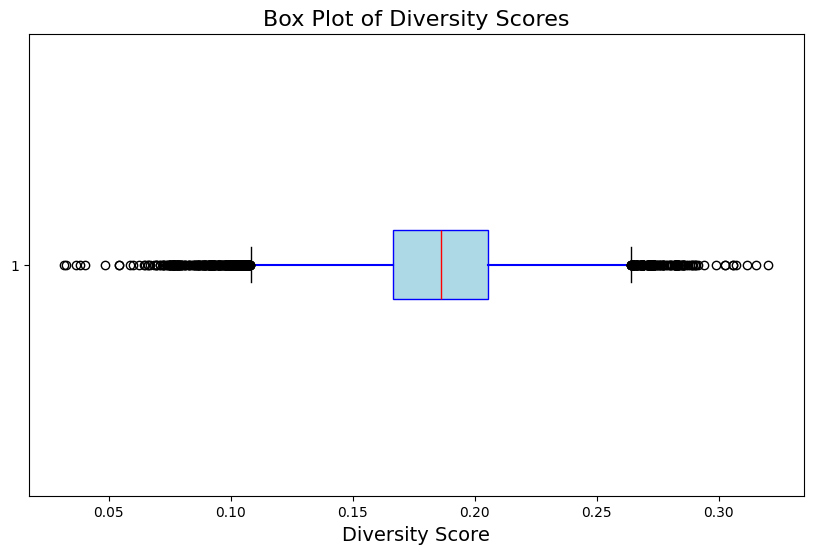

In [ ]:
import matplotlib.pyplot as plt

def plot_diversity_boxplot(diversities):
    plt.figure(figsize=(10, 6))
    plt.boxplot(diversities, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='blue', linewidth=1.5), medianprops=dict(color='red'))
    plt.title('Box Plot of Diversity Scores', fontsize=16)
    plt.xlabel('Diversity Score', fontsize=14)
    plt.show()

# Example usage
# diversities = [0.1715, 0.432, 0.245, 0.876, 0.543, 0.332]  # Replace with your actual diversity scores
plot_diversity_boxplot(diversities)


## Using Diversity into loss

This code defines and trains the model to predict binary labels, incorporating a new objective: the diversity of predictions, alongside accuracy. It uses a custom loss function that combines the usual loss for binary classification (BinaryCrossentropy) with an additional loss function for measuring the diversity of the model's outputs. The diversity is calculated based on the predictions (embeddings) generated by the model during each training epoch. Here are the key steps in this process:

Diversity Calculation:

During training, the model generates predictions (embeddings) for the data.
The diversity_loss function calculates the similarity of these predictions through a self dot product, creating a similarity matrix.
From this matrix, calculating the average similarity (excluding the diagonal representing the similarity of an item with itself) provides the basis for calculating diversity, which is 1 minus the average similarity.
Incorporation into the Loss Function:

The final loss function combines the standard classification loss (e.g., BinaryCrossentropy) with diversity. This is achieved by adding the diversity value, scaled by a weighting factor (lambda_diversity), to the base loss.
Adding the diversity term treats high similarity values as undesirable, encouraging the model to produce more distinct and diverse predictions.
Training:

As the model is trained, TensorFlow automatically adjusts the model's weights to minimize this combined loss, balancing the need for high accuracy and high diversity in predictions.
Thus, diversity is not just a metric for evaluation but becomes a central part of how the model learns and adapts, seeking a good compromise between accuracy and diversity in its predictions.

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy

def diversity_loss(embeddings, lambda_diversity=0.1):
    similarity_matrix = tf.matmul(embeddings, embeddings, transpose_b=True)
    upper_triangle = tf.linalg.band_part(similarity_matrix, 0, -1)
    num_elements = tf.cast(tf.shape(upper_triangle)[0], tf.float32)  # Convert to float32
    average_similarity = tf.reduce_mean(upper_triangle) - tf.linalg.trace(upper_triangle) / num_elements
    diversity = 1 - average_similarity
    return lambda_diversity * diversity


class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, lambda_diversity=0.1, name="custom_loss"):
        super(CustomLoss, self).__init__(name=name)
        self.lambda_diversity = lambda_diversity
        self.base_loss = BinaryCrossentropy()

    def call(self, y_true, y_pred):
        # Base loss
        base_loss_value = self.base_loss(y_true, y_pred)
        # Add diversity loss
        diversity_value = diversity_loss(y_pred, self.lambda_diversity)
        return base_loss_value + diversity_value

# In compile of model, use CustomLoss
model.compile(optimizer=optimizer,
              loss=CustomLoss(lambda_diversity=0.1),
              metrics=[tf.keras.metrics.AUC(name="auc")])


In [ ]:
# Train the model
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs_num,
    callbacks=[reduce_lr]
)


Epoch 1/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - auc: 0.7814 - loss: 0.3554 - val_auc: 0.7117 - val_loss: 0.3795 - learning_rate: 8.7070e-04
Epoch 2/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - auc: 0.7846 - loss: 0.3546 - val_auc: 0.7216 - val_loss: 0.3750 - learning_rate: 8.6364e-04
Epoch 3/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - auc: 0.7863 - loss: 0.3541 - val_auc: 0.7228 - val_loss: 0.3752 - learning_rate: 8.5664e-04
Epoch 4/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - auc: 0.7877 - loss: 0.3536 - val_auc: 0.7230 - val_loss: 0.3762 - learning_rate: 8.4969e-04
Epoch 5/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - auc: 0.7907 - loss: 0.3529 - val_auc: 0.7206 - val_loss: 0.3768 - learning_rate: 8.4279e-04
Epoch 6/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - auc: 0.7935 - loss: 0.3520 - val_auc: 0.7202 - val_loss: 0.3778 - learning_rate: 8.3596e-04
Epoch 7/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - auc: 0.7964 - loss: 0.3512 - val_auc: 0.7205 - val_loss:

## Serendipity

In [ ]:
predictions = model.predict(test_dataset)
labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Flatten arrays
predictions_flat = predictions.flatten()
labels_flat = labels.flatten()

# Compute AUC
auc_score = roc_auc_score(labels_flat, predictions_flat)
print(f"AUC on test data: {auc_score:.4f}")

In [ ]:
from collections import Counter

clicked_articles_test = df_test_behaviors['article_ids_clicked'].tolist()

# Ensure that IDs are strings (to match other data formats)
clicked_articles_test = [[str(article) for article in articles] for articles in clicked_articles_test]

# Count the frequency of articles in the training set
article_counts = Counter(df_train_behaviors['article_id'])
# Extract the Top-K most popular articles (e.g., Top-10)
baseline_articles = [article for article, _ in article_counts.most_common(10)]

# Ensure that IDs are strings
baseline_articles = [str(article) for article in baseline_articles]

# Convert clicked articles to integers
clicked_articles_test = [[int(article) for article in articles] for articles in clicked_articles_test]


KeyError: 'article_ids_clicked'

In [ ]:
def calculate_serendipity(recommendations, clicked_articles, baseline_articles):
    """
    Calculate the Serendipity Score for recommendations.

    Args:
        recommendations (list of list): Lists of recommended article IDs for each user.
        clicked_articles (list of list): Lists of article IDs clicked by each user.
        baseline_articles (list): List of popular article IDs used as a baseline.

    Returns:
        float: Average Serendipity Score across all users.
    """
    serendipities = []
    for rec_list, clicked in zip(recommendations, clicked_articles):
        # Unexpected recommendations: not in baseline
        unexpected = [article for article in rec_list if article not in baseline_articles]

        # Relevant unexpected recommendations: clicked by the user
        relevant = [article for article in unexpected if article in clicked]

        # Serendipity score for the user
        serendipity_score = len(relevant) / len(rec_list) if len(rec_list) > 0 else 0
        serendipities.append(serendipity_score)

    return serendipities
serendipities = calculate_serendipity(article_id_recommendations_test, clicked_articles_test, baseline_articles)
serendipity_score = np.mean(serendipities)
print(f"Serendipity Score: {serendipity_score:.4f}")

Serendipity measures the extent to which a recommendation system provides unexpected yet relevant recommendations to the user. It goes beyond accuracy by evaluating whether the recommendations surprise the user in a positive way.

A Serendipity Score of 0.1173 indicates that the system provides a small percentage of unexpected but relevant recommendations to the users.

In [ ]:
def plot_serendipity_histogram(serendipities):
    plt.figure(figsize=(10, 6))
    plt.hist(serendipities, bins=20, color='green', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Serendipity Scores', fontsize=16)
    plt.xlabel('Serendipity Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage
plot_serendipity_histogram(serendipities)


## Novelty

In [ ]:
# Total number of articles in the training set
total_count = sum(article_counts.values())

# Create article_popularity dictionary
article_popularity = {article: count / total_count for article, count in article_counts.items()}

In [ ]:
def calculate_novelty(recommendations, article_popularity):
    """
    Calculate the Novelty Score for recommendations.

    Args:
        recommendations (list of list): Lists of recommended article IDs for each user.
        article_popularity (dict): Dictionary mapping article IDs to popularity probabilities.

    Returns:
        float: Average Novelty Score across all users.
    """
    novelty_scores = []
    for rec_list in recommendations:
        novelty_sum = 0
        for article in rec_list:
            # Get the popularity of the article, default to a very small probability
            prob = article_popularity.get(article, 1e-6)
            novelty_sum += -np.log(prob)

        # Average novelty score for the user's recommendation list
        novelty_scores.append(novelty_sum / len(rec_list) if len(rec_list) > 0 else 0)

    return novelty_scores
novelty_scores = calculate_novelty(article_id_recommendations_test, article_popularity)
novelty_score = np.mean(novelty_scores)
print(f"Novelty Score: {novelty_score:.4f}")

Novelty measures how "new" or "unfamiliar" the recommended items are to the user, often based on their global popularity:

Highly popular items are considered less novel because they are likely to be known by most users.
Less popular items are considered more novel because they have a higher likelihood of being new to the user.

A Novelty Score of 13.8155 indicates that the recommended articles are highly novel, meaning the system suggests articles that are generally less popular and not commonly seen by users.

In [ ]:
def plot_novelty_histogram(novelty_scores):
    plt.figure(figsize=(10, 6))
    plt.hist(novelty_scores, bins=20, color='orange', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Novelty Scores', fontsize=16)
    plt.xlabel('Novelty Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage
plot_novelty_histogram(novelty_scores)

In [ ]:
total_articles = embedding_matrix.shape[0]


In [ ]:
def calculate_item_coverage(recommendations, total_articles):
    """
    Calculate the Item Coverage for recommendations.

    Args:
        recommendations (list of list): Lists of recommended article IDs for each user.
        total_articles (int): Total number of articles available in the catalog.

    Returns:
        float: Coverage Score as a fraction of total articles covered.
    """
    # Unique articles recommended across all users
    recommended_articles = set(article for rec_list in recommendations for article in rec_list)

    # Coverage is the fraction of unique articles recommended
    return recommended_articles, len(recommended_articles) / total_articles
recommended_articles,_ = calculate_item_coverage(article_id_recommendations_test, total_articles)
_,coverage_score = calculate_item_coverage(article_id_recommendations_test, total_articles)
print(f"Item Coverage Score: {coverage_score:.4f}")

Coverage evaluates how well the recommendation system utilizes the available content:

High Coverage: Suggests that the system explores a wide variety of articles.
Low Coverage: Indicates that the system focuses only on a limited set of articles, potentially overlooking many others.

An Item Coverage Score of 0.0316 means that the recommendation system uses only about 3.16% of the total articles in the catalog across all its recommendations.
This indicates a strong bias toward a small subset of articles, likely the most relevant or popular ones.

In [ ]:
def plot_coverage_pie(recommended_articles, total_articles):
    coverage_score = len(recommended_articles) / total_articles
    plt.figure(figsize=(8, 6))
    plt.pie(
        [coverage_score, 1 - coverage_score],
        labels=["Covered", "Not Covered"],
        autopct="%1.1f%%",
        colors=["lightblue", "lightgrey"],
        startangle=140
    )
    plt.title("Proportion of Catalog Covered", fontsize=16)
    plt.show()

# Example usage
plot_coverage_pie(recommended_articles, total_articles)